# Age vs. Hospitalization

I want to know how age effects the probability of hospitalization.

This analysis is based on the case data in this google sheet:

https://docs.google.com/spreadsheets/d/1itaohdPiAeniCXNlntNztZ_oRvjh0HsGuJXUJWET008/edit?usp=sharing

I exported it to an xlsx. I don't know if the data is reliable or not.

In [5]:
import pandas as pd
import datetime
import numpy as np

In [2]:
# this will by default read the first sheet
df = pd.read_excel("COVID19_2020_open_line_list.xlsx")

In [3]:
counts = df.groupby("country").count()['ID']

In [4]:
counts.sort_values()

country
Afghanistan          1
Ireland              1
Jordan               1
Liechtenstein        1
Lithuania            1
                 ...  
Italy              588
Japan              751
South Korea        938
Iran               995
China            10594
Name: ID, Length: 70, dtype: int64

Most of the data is from China, as we'd expect.

I'm going to run this analysis on all data, including China, since once we filter for
records that include age, we won't have much left anyways.

In [6]:
df['age'].unique()

array([30, 47, 49, 50, nan, 42, 59, 39, 38, 45, 33, 37, 32, 18, 56, 44,
       65, 21, 41, 70, 43, 31, 24, 40, 66, 36, 10, 63, 78, 76, 48, 62, 46,
       34, 72, 20, 54, 2, 29, 61, 51, 80, 69, 28, 55, 68, 57, 35, 27, 52,
       22, 23, 88, 19, 60, 58, 53, 25, '36-45', 26, 64, '30-39', 11,
       '50-59', 73, 74, 7, 82, 67, 15, 16, '60-69', '40-49', '80-89',
       '27-40', 5, 3, 4, 71, '20-29', 77, 75, '16-80', 94, '38-68',
       '23-72', 81, 0.58333, 17, 8, 9, 0.08333, 12, 0.5, 83, 84, '60-60',
       1, 79, 87, '22-80', '19-77', 'Aug-68', '21-72', '40-89', 0.25,
       '13-19', '70-79', '80-80', '0-6', '0-10',
       datetime.datetime(2020, 10, 19, 0, 0), 96, 1.75, '18-65', '0-18',
       '65-99', '90-99', '50-69', 92], dtype=object)

Tons of weird shit in there. I'm going to replace the wider ranges with `NaN` (they're
uninformative) and replace the tighter ranges with their midpoint.

Replacement rules can be seen below.

In [7]:
ages_cleaned = df['age'].replace(
    to_replace={
        datetime.datetime(2020, 10, 19, 0, 0): np.nan,
        0.5: np.nan,
        'Aug-68': np.nan,
        '60-60': 60,
        '16-80': np.nan,
        '36-45': 40,
        '30-39': 35,
        '50-59': 55,
        '60-69': 65,
        '40-49': 45,
        '70-79': 75,
        '80-89': 85,
        '27-40': 34,
        '20-29': 25,
        '90-99': 95,
        '38-68': np.nan,
        '23-72': np.nan,
        '22-80': np.nan,
        '19-77': np.nan,
        '21-72': np.nan,
        '40-89': np.nan,
        '13-19': 16,
        '80-80': 80,
        '0-6': 3,
        '0-10': 5,
        '18-65': np.nan,
        '0-18': 9,
        '65-99': 75,
        '50-69': 60
    }
)

We also have some ages that are `0.5`, and other shit like that. Get rid of those.

In [8]:
df['age'] = [age if age > 2 else np.nan for age in ages_cleaned]

In [9]:
df['age'].unique()

array([30., 47., 49., 50., nan, 42., 59., 39., 38., 45., 33., 37., 32.,
       18., 56., 44., 65., 21., 41., 70., 43., 31., 24., 40., 66., 36.,
       10., 63., 78., 76., 48., 62., 46., 34., 72., 20., 54., 29., 61.,
       51., 80., 69., 28., 55., 68., 57., 35., 27., 52., 22., 23., 88.,
       19., 60., 58., 53., 25., 26., 64., 11., 73., 74.,  7., 82., 67.,
       15., 16., 85.,  5.,  3.,  4., 71., 77., 75., 94., 81., 17.,  8.,
        9., 12., 83., 84., 79., 87., 96., 95., 92.])

Looks reasonable.

**What's the overall probability of hospitalization?**

In [10]:
df['date_admission_hospital'].dropna().count() / df['ID'].count()

0.05123469457555236

In this data, it's only 5%, which seems low based on what we've been hearing.

In [ ]:
hospitalized = df[~df['date_admission_hospital'].isnull()]
non_hospitalized = df[df['date_admission_hospital'].isnull()]

In [11]:
df['hospitalized'] = ~df['date_admission_hospital'].isnull()

We'll do a logistic regression, to see how probability of hospitalization changes with
age. 

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
with_age = df[~df['age'].isnull()]

In [15]:
with_age[with_age['hospitalized']]['ID'].count() / with_age['ID'].count()

0.5558139534883721

So for those records that include an age, over half are hospitalized. This is much
_higher_ than what we've generally been hearing.

In [16]:
X = np.array(with_age['age']).reshape(-1, 1)
y = np.array(with_age['hospitalized'])

In [17]:
clf = LogisticRegression(random_state=0).fit(X, y)

/Users/peterwills/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
ages = np.arange(0, 100).reshape(-1, 1)

In [19]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'probability_hospitalized')

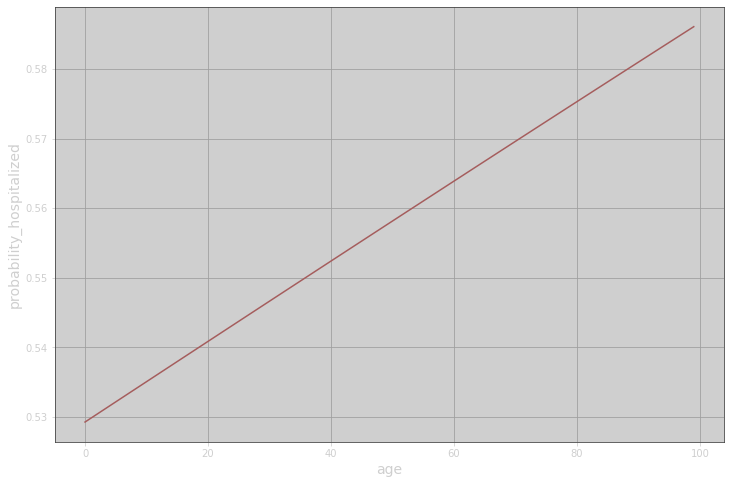

In [21]:
plt.figure(figsize=(12,8))

plt.plot(ages, [p[1] for p in clf.predict_proba(ages)])
plt.xlabel('age')
plt.ylabel('probability_hospitalized')


So with our trained regressor, age doesn't actually have that strong of an impact on
probability of hospitalization.

Getting uncertainties here would be useful.

# Conclusion

I don't think the data is reliable enough to draw any meaningful conclusions from
this. I suspect there is correlation between which records have an age recorded and
which have a hospitalization date recorded, which would make any results we draw invalid.